# Surplus Study

1. Load Data 

In [179]:
import pandas as pd 

# load raw trades data of COW swap 
df = pd.read_csv('cow_swaps.csv', low_memory=False)

In [180]:
# prepare table structure and needed columns for analysis 

df['buy_amount'] = df.apply(lambda x: x['buyAmount'] / (10**x['buyTokenDecimals']), axis=1)
df['sell_amount'] = df.apply(lambda x: x['sellAmount'] / (10**x['sellTokenDecimals']), axis=1)
df = df[['timestamp', 'buyTokenSymbol', 'sellTokenSymbol', 'buy_amount', 'sell_amount','sellAmountUsd']]
df = df.rename(columns={"sellAmountUsd": "trade_value_usd", "buyTokenSymbol":"buy_token", "sellTokenSymbol":"sell_token"})

df['price'] = 0.0                  # .iloc 6
df['surplus_usdt'] = 0.0           # .iloc 7 
df['surplus_price'] = 0.0          # .iloc 8 
df['surplus_percent'] = 0.0        # .iloc 9
df['executed'] = False             # .iloc 10 


df['price'] = df['price'].astype(float)
df['surplus_usdt'] = df['surplus_usdt'].astype(float)
df['surplus_price'] = df['surplus_price'].astype(float)
df['surplus_percent'] = df['surplus_percent'].astype(float)
df['executed'] = df['executed'].astype(bool)

print(df.head(5))

    timestamp buy_token sell_token   buy_amount   sell_amount  \
0  1663907363       FXS       USDC   917.011543   4093.394367   
1  1668043871       FXS       USDC  8621.106771  45331.499213   
2  1669126187       FXS       USDC  1583.112031   6719.000000   
3  1662029515       FXS       USDC   369.820837   2138.328191   
4  1653185840       FXS       USDC  8901.647728  59366.191057   

   trade_value_usd  price  surplus_usdt  surplus_price  surplus_percent  \
0      4093.394367    0.0           0.0            0.0              0.0   
1     45331.499213    0.0           0.0            0.0              0.0   
2      6719.000000    0.0           0.0            0.0              0.0   
3      2138.328191    0.0           0.0            0.0              0.0   
4     59366.191057    0.0           0.0            0.0              0.0   

   executed  
0     False  
1     False  
2     False  
3     False  
4     False  


In [183]:
def surplus_analysis(token1:str, token2:str, token1_starting_reserves:int, fee_rate:float):
    
    """
    Perform surplus analysis for specific trading pair given by token1 and token2. 

    This function filters the required tokens for the simulation, initializes a feedlot AMM (CPMM) with starting 
    price corresponding to first trade in the list and a given initial reserves, loops through trade by trade and 
    checks if Pfeedlot < Pmarket. If yes (k_new > k_current), it executes the trade in Feedlot using the standard 
    CPMM formula. 

    Parameters:
        token1 (str): The first token to perform the surplus analysis on.
        token2 (str): The second token to perform the surplus analysis on.
        token1_starting_reserves (int): The starting reserves of token1.
        fee_rate (float): The fee rate for the transactions.

    Returns:
        
    """
    
    
    # Filter the required tokens for the simulation 
    dfs = df[((df.buy_token == token1) & (df.sell_token == token2)) | ((df.sell_token == token1) & (df.buy_token == token2))]
    dfs.sort_values(by='timestamp', ascending=True, inplace=True)
    dfs = dfs[dfs['trade_value_usd'] > 100]
    dfs = dfs.reset_index(drop=True)
    
    # Calculate price column. Check if its a buy or a sell and calculate accordingly. 
    for i in range(len(dfs)):
        if dfs.iloc[i,1] == token1:
            dfs.iloc[i,6] = dfs.iloc[i,3] / dfs.iloc[i,4]  

        if dfs.iloc[i,1] == token2:
            dfs.iloc[i,6] = dfs.iloc[i,4] / dfs.iloc[i,3]
            
    dfs = dfs[dfs['price'] != 0]
    
    # initialize AMM pool 
    s = fee_rate 
    initialization_price = dfs.iloc[0,6]  
    token2_starting_reserves = token1_starting_reserves / initialization_price
    x = token1_starting_reserves 
    y = token2_starting_reserves 
    k = x * y 
    
    print('''AMM Initialized with the following parameters:
    initilization price = {}
    x= {}
    y= {}
    k= {}
    s= {}'''.format(initialization_price, token1_starting_reserves, token2_starting_reserves, k, s))
    

    # Iterating through trades and checking if the trade would have been executed through Feedlot AMM
    # The condition is k_new > k  
    # Variables to monitor (trades: total trades executed, fees: total fees collected, volume : total volume executed) 

    trades  = 0 
    fees = 0 
    volume = 0 
    
    for i in range(len(df)):

        # if token_1 is the "buy token"
        if df.iloc[i,1] == token1:
            dx = df.iloc[i,3]
            dy = df.iloc[i,4]
            k_new = (x - dx) * (y + (1+s)*dy) 

            if k_new > k:
                surplus_price = abs((x / y)- df.iloc[i,6])
                df.iloc[i,7] =  surplus_price * dy 
                df.iloc[i,8] = surplus_price
                df.iloc[i,9] = surplus_price / df.iloc[i,6] * 100 # percentage
                df.iloc[i,10] = 1 # trade executed signal 
                volume = volume + df.iloc[i,5]
                fees = fees + (s * df.iloc[i,5]) 
                trades = trades + 1 
                k = k_new 
                x = x - dx
                y = y + (1+s)*dy 



        # if token_2 is the "buy token"
        elif df.iloc[i,1] == token2:
            dx = df.iloc[i,4] 
            dy = df.iloc[i,3]
            k_new = (x + (1+s)*dx) * (y - dy)    

            if k_new > k: 
                surplus_price = abs((x / y)- df.iloc[i,6])
                df.iloc[i,7] =  surplus_price * dy 
                df.iloc[i,8] = surplus_price
                df.iloc[i,9] = surplus_price / df.iloc[i,6] * 100 # percentage
                df.iloc[i,10] = 1 # trade executed signal 
                volume = volume + df.iloc[i,5]
                fees = fees + (s * df.iloc[i,5]) 
                trades = trades + 1 
                k = k_new 
                x = x - dx
                y = y + (1+s)*dy 


    # Analysis results 
    
    total_trades = len(dfs) 
    total_volume = df['trade_value_usd'].sum()
    total_surplus = df['surplus_usdt'].sum() 

    trades_executed_percentage = trades / total_trades * 100 
    executed_volume_percentage = volume / total_volume * 100 
    total_surplus_percentage = total_surplus/ total_volume *100
    
    print('total surplus', total_surplus)
    print('surplus percentage of volume', total_surplus_percentage, '%')
    print('trades executed = ', trades)
    print('total_trades= ', total_trades)
    print('percentage of trades executed = ', trades_executed_percentage, '%') 
    
    print('total usd volume traded on feedlot= ', volume)
    print('total USD volume traded on COW', total_volume)
    print('volume percentage = ', volume / total_volume *100 , '%')
    print('fees collected', fees)  
    
    return trades_executed_percentage, total_surplus
                


In [184]:
surplus_analysis('USDC', 'WETH', 1000000000, 0)

/tmp/ipykernel_19979/3836650152.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='timestamp', ascending=True, inplace=True)


AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 1000000000
    y= 366507.10047033493
    k= 366507100470334.94
    s= 0


/tmp/ipykernel_19979/3836650152.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  df.iloc[i,9] = surplus_price / df.iloc[i,6] * 100 # percentage


total surplus 10516982.398047127
surplus percentage of volume 0.06577463432630627 %
trades executed =  11
total_trades=  24990
percentage of trades executed =  0.04401760704281713 %
total usd volume traded on feedlot=  9049516.350560026
total USD volume traded on COW 15989419790.420494
volume percentage =  0.056596902634213964 %
fees collected 0.0


(0.04401760704281713, 0.06577463432630627)

/tmp/ipykernel_19979/3836650152.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='timestamp', ascending=True, inplace=True)


AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 10000000
    y= 3665.0710047033494
    k= 36650710047.03349
    s= 0


/tmp/ipykernel_19979/3836650152.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  df.iloc[i,9] = surplus_price / df.iloc[i,6] * 100 # percentage


total surplus 250066626.22447586
surplus percentage of volume 1.5639505967208054 %
trades executed =  12
total_trades=  24990
percentage of trades executed =  0.04801920768307323 %
total usd volume traded on feedlot=  23528511.700459525
total USD volume traded on COW 15989419790.420494
volume percentage =  0.14715050332567925 %
fees collected 0.0
AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 60000000
    y= 21990.426028220096
    k= 1319425561693.2058
    s= 0
total surplus 213040805.02323973
surplus percentage of volume 1.3323860891492494 %
trades executed =  11
total_trades=  24990
percentage of trades executed =  0.04401760704281713 %
total usd volume traded on feedlot=  9049516.350560026
total USD volume traded on COW 15989419790.420494
volume percentage =  0.056596902634213964 %
fees collected 0.0
AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 110000000
    y= 40315.78105173684
    k= 4434735915

AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 860000000
    y= 315196.10640448803
    k= 271068651507859.72
    s= 0
total surplus 134051130.37509619
surplus percentage of volume 0.8383739506008108 %
trades executed =  11
total_trades=  24990
percentage of trades executed =  0.04401760704281713 %
total usd volume traded on feedlot=  9049516.350560026
total USD volume traded on COW 15989419790.420494
volume percentage =  0.056596902634213964 %
fees collected 0.0
AMM Initialized with the following parameters:
    initilization price = 2728.4601
    x= 910000000
    y= 333521.4614280048
    k= 303504529899484.4
    s= 0
total surplus 133709963.67196728
surplus percentage of volume 0.8362402477673078 %
trades executed =  11
total_trades=  24990
percentage of trades executed =  0.04401760704281713 %
total usd volume traded on feedlot=  9049516.350560026
total USD volume traded on COW 15989419790.420494
volume percentage =  0.056596902634213964 %
f

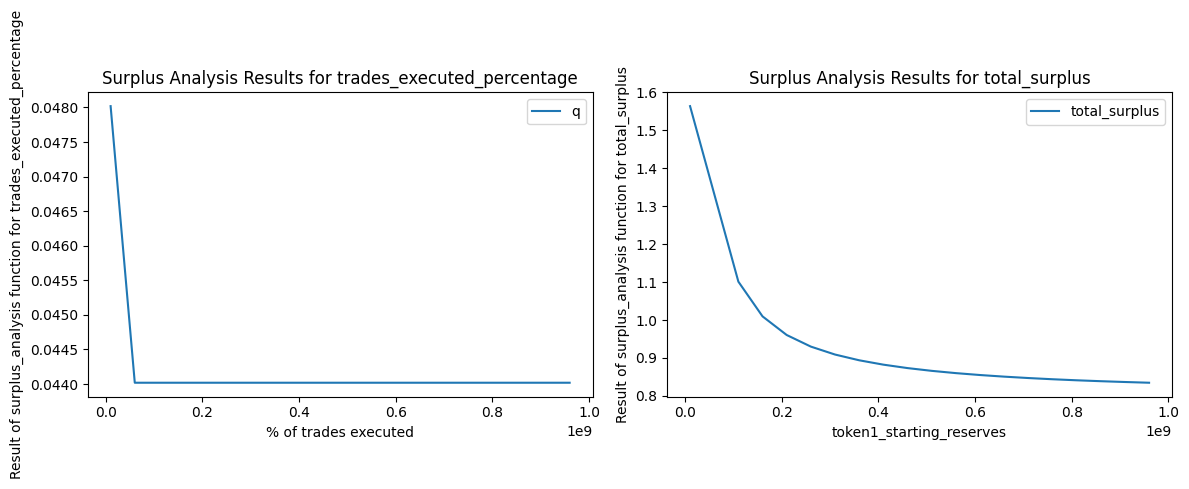

In [187]:
import matplotlib.pyplot as plt


token1 = "USDC"
token2 = "WETH"
fee_rate = 0

x = []
y1 = []
y2 = []

#range from 10mln to 1bn in 50mn increments
for token1_starting_reserves in range(10000000, 1010000000, 50000000):
    x.append(token1_starting_reserves)
    q, w = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1.append(q)
    y2.append(w)
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(x, y1, label='q')
ax1.set_xlabel('% of trades executed')
ax1.set_ylabel('Result of surplus_analysis function for trades_executed_percentage')
ax1.set_title('Surplus Analysis Results for trades_executed_percentage')
ax1.legend()

ax2.plot(x, y2, label='total_surplus')
ax2.set_xlabel('token1_starting_reserves')
ax2.set_ylabel('Result of surplus_analysis function for total_surplus')
ax2.set_title('Surplus Analysis Results for total_surplus')
ax2.legend()

plt.tight_layout()
plt.show()
